# Time Series Forecasting

## Import libraries

In [1]:
#!pip install etna[prophet]
#!pip install -U typing_extensions
# restart kernel after installing

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from etna.datasets import TSDataset
from etna.analysis.outliers import get_anomalies_prediction_interval
from etna.analysis import plot_anomalies
from etna.models import ProphetModel
from etna.analysis import plot_trend
from etna.transforms import LinearTrendTransform
from etna.analysis import acf_plot

from statsmodels.tsa.stattools import adfuller


import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.8/site-packages/etna/settings.py:37: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
/opt/conda/lib/python3.8/site-packages/etna/settings.py:45: UserWarning: wandb is not available, to install it, run `pip install etna[wandb]`
  warnings.warn("wandb is not available, to install it, run `pip install etna[wandb]`")
/opt/conda/lib/python3.8/site-packages/etna/settings.py:62: UserWarning: etna[classification] is not available, to install it, run `pip install etna[classification]`
  warnings.warn("etna[classification] is not available, to install it, run `pip install etna[classification]`")
/opt/conda/lib/python3.8/site-packages/etna/settings.py:71: UserWarning: etna[auto] is not available, to install it, run `pip install etna[auto]`
  warnings.warn("etna[auto] is not available, to install it, run `pip install etna[auto]`")
/opt/conda/l

In [3]:
from clickhouse_driver import Client


user_name = 'user_name'
pwd = 'password'

# creating connection ClickHouse
client = Client(host='clickhouse.lab.karpov.courses', port=9000,
                user=user_name, password=pwd, database='hardda')

# checking connection
result = client.execute("SELECT * FROM hardda.user_dm_events LIMIT 1")

# showing the result
for row in result[0:1]:
    print(row)

(datetime.date(2022, 2, 1), datetime.date(2022, 1, 31), 'android', 'f7411212fd0e2523e126cbfdd3f226c211212', '4beb10e1-aeeb-4c52-acd2-ce1ddbc1fc24b10e1', 22, 11, 3, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0)


## Tasks

### Task 1.

 **Write an SQL query to load the data.**

`live_adverts`

In [4]:
user_passports_desc = client.execute("""
DESCRIBE TABLE live_adverts
""")

user_passports_desc

[('execution_date', 'Date32', '', '', '', 'DoubleDelta', ''),
 ('advert_id', 'UInt64', '', '', '', 'T64', ''),
 ('created_at', 'DateTime', '', '', '', 'DoubleDelta', ''),
 ('price', 'UInt64', '', '', '', 'Gorilla', ''),
 ('region', 'LowCardinality(String)', '', '', '', '', ''),
 ('user_id', 'UInt32', '', '', '', 'T64', ''),
 ('platform', 'LowCardinality(String)', '', '', '', '', ''),
 ('auto_brand', 'LowCardinality(String)', '', '', '', '', ''),
 ('auto_model', 'LowCardinality(String)', '', '', '', '', ''),
 ('passport_id', 'UInt32', '', '', '', 'T64', ''),
 ('year', 'LowCardinality(String)', '', '', '', '', ''),
 ('userType', 'UInt8', '', '', '', 'T64', '')]

In [5]:
query = '''
SELECT 
  execution_date,
  COUNT(DISTINCT(advert_id)) AS adv_cnt
FROM 
  live_adverts
GROUP BY
  execution_date
ORDER BY
  execution_date DESC
'''

In [6]:
result = client.execute(query)

In [7]:
len(result)

365

In [8]:
df = pd.DataFrame(result, 
                  columns=['execution_date', 'adv_cnt'])

df

,execution_date,adv_cnt
0,2023-01-31,256164
1,2023-01-30,255049
2,2023-01-29,247541
3,2023-01-28,238837
4,2023-01-27,241452
...,...,...
360,2022-02-05,253061
361,2022-02-04,255914
362,2022-02-03,260833
363,2022-02-02,265165


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   execution_date  365 non-null    object
 1   adv_cnt         365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [10]:
df['execution_date'] = pd.to_datetime(df['execution_date'])

### Task 2. 

**What data span do we have?**

In [11]:
min_date = df.execution_date.min()
max_date = df.execution_date.max()

print(f'Our data is from {min_date} to {max_date}.')

Our data is from 2022-02-01 00:00:00 to 2023-01-31 00:00:00.


### Task 3.  

**Is there any missing dates?** 

In [12]:
dateset = pd.date_range(start=min_date, end=max_date).date
missing_dates = pd.Series([x for x in dateset if x not in df.execution_date.dt.date.values])

missing_dates.value_counts()

Series([], dtype: int64)

### Task 4. 

**Find the date with the lowest number of adverts?**  

In [13]:
df[df['adv_cnt'] == df.adv_cnt.min()]

,execution_date,adv_cnt
31,2022-12-31,179438


### Task 5. 

**Convert the DataFrame to an object of the etna.datasets.TSDataset class and plot the time series on a graph.**

In [14]:
data = (
    df.rename({'adv_cnt':'target', 'execution_date':'timestamp'}, axis=1)
)
data['segment'] = 'main'
data

,timestamp,target,segment
0,2023-01-31,256164,main
1,2023-01-30,255049,main
2,2023-01-29,247541,main
3,2023-01-28,238837,main
4,2023-01-27,241452,main
...,...,...,...
360,2022-02-05,253061,main
361,2022-02-04,255914,main
362,2022-02-03,260833,main
363,2022-02-02,265165,main


In [15]:
df_daily = TSDataset.to_dataset(data)
df_daily = TSDataset(df_daily, freq="D")

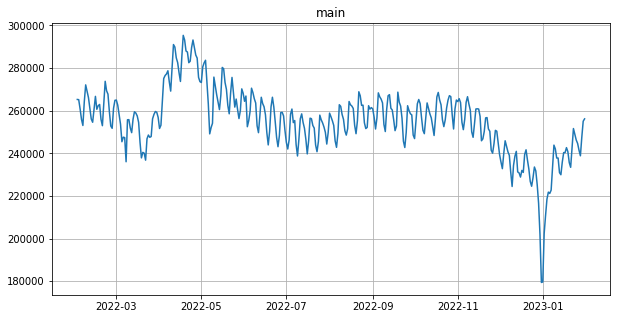

In [16]:
df_daily.plot()

### Task 6. 

**Use `get_anomalies_prediction_interval` to find anomalies in your data.**

12:12:01 - cmdstanpy - INFO - Chain [1] start processing
12:12:01 - cmdstanpy - INFO - Chain [1] done processing


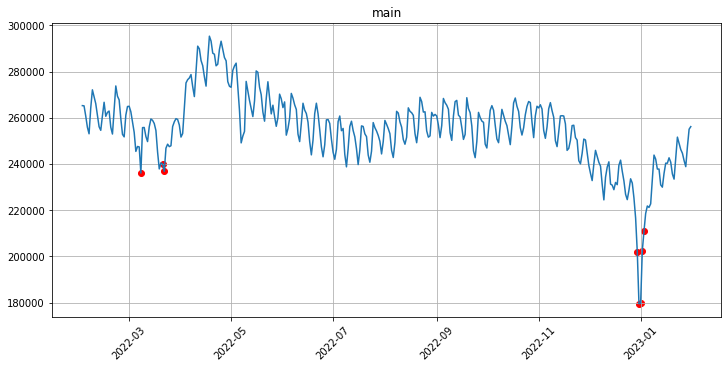

In [17]:
np.random.seed(42)
anomalies_model = get_anomalies_prediction_interval(
    df_daily, model=ProphetModel, interval_width=0.999
)

plot_anomalies(df_daily, anomalies_model)

In [18]:
anomalies_model

{'main': [numpy.datetime64('2022-03-08T00:00:00.000000000'),
  numpy.datetime64('2022-03-21T00:00:00.000000000'),
  numpy.datetime64('2022-03-22T00:00:00.000000000'),
  numpy.datetime64('2022-12-30T00:00:00.000000000'),
  numpy.datetime64('2022-12-31T00:00:00.000000000'),
  numpy.datetime64('2023-01-01T00:00:00.000000000'),
  numpy.datetime64('2023-01-02T00:00:00.000000000'),
  numpy.datetime64('2023-01-03T00:00:00.000000000')]}

### Task 7. 

**Find an average value of ads if we exclude anomalies.**

In [19]:
lst = [np.datetime64('2022-03-08T00:00:00.000000000'),
  np.datetime64('2022-03-21T00:00:00.000000000'),
  np.datetime64('2022-03-22T00:00:00.000000000'),
  np.datetime64('2022-12-30T00:00:00.000000000'),
  np.datetime64('2022-12-31T00:00:00.000000000'),
  np.datetime64('2023-01-01T00:00:00.000000000'),
  np.datetime64('2023-01-02T00:00:00.000000000'),
  np.datetime64('2023-01-03T00:00:00.000000000')]

In [20]:
df.query('execution_date not in @lst').adv_cnt.mean()

256113.7142857143

### Task 8. 

**Use `plot_trend` to graph the data.**

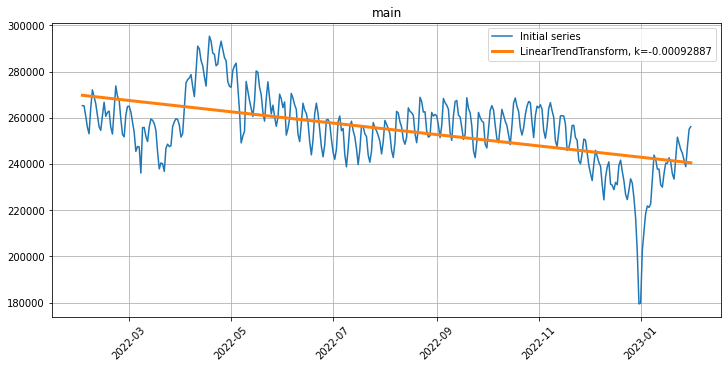

In [21]:
plot_trend(ts=df_daily, trend_transform=LinearTrendTransform(in_column='target'))

### Task 9. 

**Build autocorrealtion graph.**

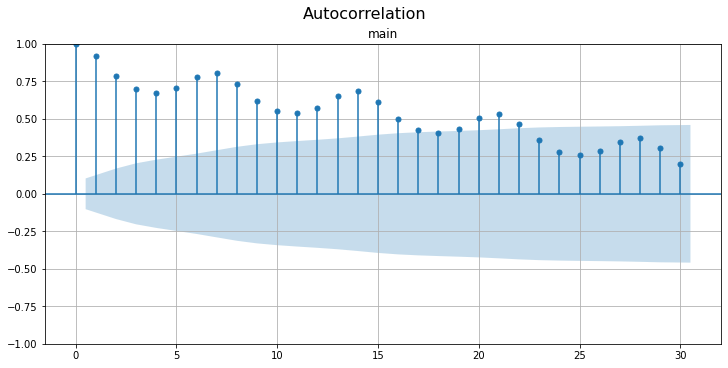

In [22]:
acf_plot(df_daily, lags=30)

### Task 10. 

**Perform Augmented Dickey-Fuller unit root test to whether the time series is stationary or not.**

In [23]:
result = adfuller(df_daily.to_pandas().dropna()[('main', 'target')], regression='ct')
result

(-2.9884001808071408,
 0.13535295704421402,
 14,
 350,
 {'1%': -3.9848711942857142,
  '5%': -3.42310882155102,
  '10%': -3.1344699913702625},
 6777.324961312952)

In [24]:
alpha = 0.05

if result[1] < alpha:
    print('Time series is stationary.')
else:
    print('Time series is NOT stationary.')

Time series is NOT stationary.


### Task 11. 

**Plot the difference in the amount of ads. What are the min and max ads difference values?**

In [25]:
def get_ts_lineplot(
    data=pd.DataFrame,
    date_colname='observation_date',
    value_colname= 'value'
):
    plt.figure(figsize=(16, 10))
    plt.plot(data[date_colname], data[value_colname])
    plt.xticks(rotation=45)
    plt.show();

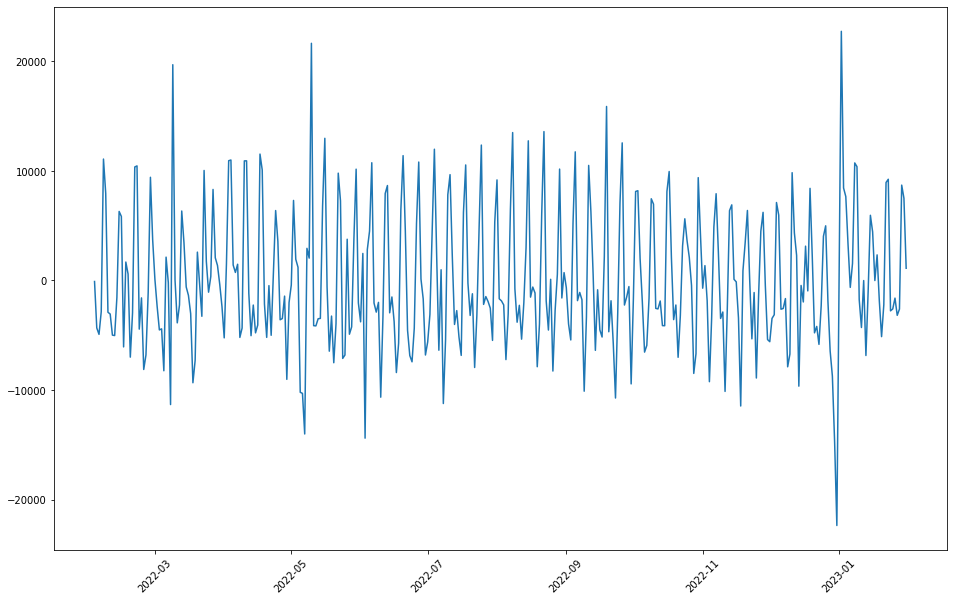

In [26]:
to_plot = df_daily.to_pandas().dropna().diff().dropna().reset_index()
to_plot.columns = ['timestamp', 'target']


get_ts_lineplot(to_plot, date_colname='timestamp', value_colname='target');

In [27]:
to_plot.target.describe()

count      364.000000
mean       -24.989011
std       6289.886058
min     -22367.000000
25%      -4123.000000
50%      -1508.500000
75%       3831.500000
max      22743.000000
Name: target, dtype: float64

### Task 12. 

**Perform Augmented Dickey-Fuller unit root test to whether the time series of differencies is stationary or not.**

In [28]:
result = adfuller(to_plot.target, regression='c')
result

(-4.758079718772276,
 6.53700534044579e-05,
 13,
 350,
 {'1%': -3.4491725955218655,
  '5%': -2.8698334971428574,
  '10%': -2.5711883591836733},
 6763.705011834962)

In [29]:
alpha = 0.05

if result[1] < alpha:
    print('Time series is stationary.')
else:
    print('Time series is NOT stationary.')

Time series is stationary.


### Task 13. 

**tbc..**